# **Cohort analysis**

Cohort analysis involves dividing users into distinct groups, or cohorts, based on certain criteria. In this case study, these cohorts are defined by the time of user acquisition. By grouping users together based on time of acquisition, we can study how different cohorts behave in terms of engagement and retention.

For example, you might create cohorts based on the month users first signed up for your service. You can then track how each cohort's activity, such as their conversion rate or lifetime value, evolves over time. This approach allows you to identify trends, anomalies, and areas where you may need to make adjustments to improve user retention and satisfaction.

**Retention Rate Time-Based Cohort Analysis:**

Retention rate time-based cohort analysis is a specialized form of cohort analysis that focuses on the retention of users over multiple time periods.

To perform retention rate time-based cohort analysis, you would typically:

- Create cohorts based on user acquisition dates.

- Measure the percentage of users from each cohort who continue to engage with your product or service over time (e.g., after 1 month, 3 months, etc.).

- Analyze how retention rates vary across different cohorts and time periods, enabling you to identify trends and make data-driven decisions.

This analysis can reveal whether certain cohorts have better or worse retention rates, helping the business understand the factors contributing to user retention or attrition. It can also assist in optimizing marketing, product development, and customer support strategies.

# Import libraries

In [1]:
!pip install lifetimes
!pip install xgboost

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import datetime as dt
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from lifetimes import BetaGeoFitter
from lifetimes.plotting import plot_probability_alive_matrix, plot_frequency_recency_matrix

from operator import attrgetter
from matplotlib.ticker import FuncFormatter
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D


import os
import warnings
warnings.filterwarnings('ignore')

# Data Loading, preprocessing and Cleaning

In [2]:
# Load dataset

df = pd.read_csv('../data/Dataset_ecommerce.csv')
df.head()

,InvoiceNo,InvoiceDate,CustomerID,StockCode,Description,Quantity,UnitPrice,Country
0,536365,2010-12-01 08:26:00,17850.0,SC1734,Electronics,65,10.23,Egypt
1,536365,2010-12-01 08:26:00,17850.0,SC2088,Furniture,95,19.61,Mali
2,536365,2010-12-01 08:26:00,17850.0,SC3463,Books,78,61.49,Mali
3,536365,2010-12-01 08:26:00,17850.0,SC6228,Toys,15,24.73,South Africa
4,536365,2010-12-01 08:26:00,17850.0,SC2149,Toys,50,38.83,Rwanda


In [3]:
df.describe(include ="all")

,InvoiceNo,InvoiceDate,CustomerID,StockCode,Description,Quantity,UnitPrice,Country
count,541909,541909,406829.000000,541909,541909,541909.000000,541909.000000,541909
unique,25900,23260,NaN,9000,10,NaN,NaN,28
top,573585,2011-10-31 14:41:00,NaN,SC2014,Sports Equipment,NaN,NaN,Cote d'Ivoire
freq,1114,1114,NaN,96,54765,NaN,NaN,19651
mean,NaN,NaN,15287.690570,NaN,NaN,50.534748,50.476354,NaN
std,NaN,NaN,1713.600303,NaN,NaN,28.849367,28.564775,NaN
min,NaN,NaN,12346.000000,NaN,NaN,1.000000,1.000000,NaN
25%,NaN,NaN,13953.000000,NaN,NaN,26.000000,25.750000,NaN
50%,NaN,NaN,15152.000000,NaN,NaN,51.000000,50.430000,NaN
75%,NaN,NaN,16791.000000,NaN,NaN,76.000000,75.180000,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   InvoiceDate  541909 non-null  object 
 2   CustomerID   406829 non-null  float64
 3   StockCode    541909 non-null  object 
 4   Description  541909 non-null  object 
 5   Quantity     541909 non-null  int64  
 6   UnitPrice    541909 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [5]:
df.isnull().sum()

InvoiceNo           0
InvoiceDate         0
CustomerID     135080
StockCode           0
Description         0
Quantity            0
UnitPrice           0
Country             0
dtype: int64

In [6]:
# Clean nulls (Drop missing column)

df.dropna(inplace = True)

#we can only track the activities of customers that are known (those with customerID)

In [7]:
# Format InvoiceDate

df["InvoiceDate"] = pd.to_datetime(df["InvoiceDate"])

In [8]:
# Create TotalPrice

df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

In [9]:
# Initial inspection

print(f'{df.info()}\n')
print(f'\n{df.describe()}\n')
print(f'\n{df.head()}')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   InvoiceDate  406829 non-null  datetime64[ns]
 2   CustomerID   406829 non-null  float64       
 3   StockCode    406829 non-null  object        
 4   Description  406829 non-null  object        
 5   Quantity     406829 non-null  int64         
 6   UnitPrice    406829 non-null  float64       
 7   Country      406829 non-null  object        
 8   TotalPrice   406829 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 31.0+ MB
None


          CustomerID       Quantity      UnitPrice     TotalPrice
count  406829.000000  406829.000000  406829.000000  406829.000000
mean    15287.690570      50.478471      50.477654    2550.053514
std      1713.600303      28.872921      28.573075   

# Exploratory data analysis

## Analysis by country

**Bivariate analysis of countries and total number of purchase**

In [10]:
quantity_per_country = df.groupby(["Country"])["Quantity"].sum().reset_index()
quantity_per_country = quantity_per_country.sort_values("Quantity", ascending = False).reset_index()

In [11]:
quantity_per_country.head(10)

,index,Country,Quantity
0,23,Togo,741223
1,20,South Africa,740589
2,4,Cote d'Ivoire,740229
3,15,Nigeria,739708
4,9,Libya,739206
5,1,Benin,738133
6,27,Zimbabwe,737522
7,19,Somalia,736219
8,0,Algeria,736181
9,18,Sierra Leone,735477


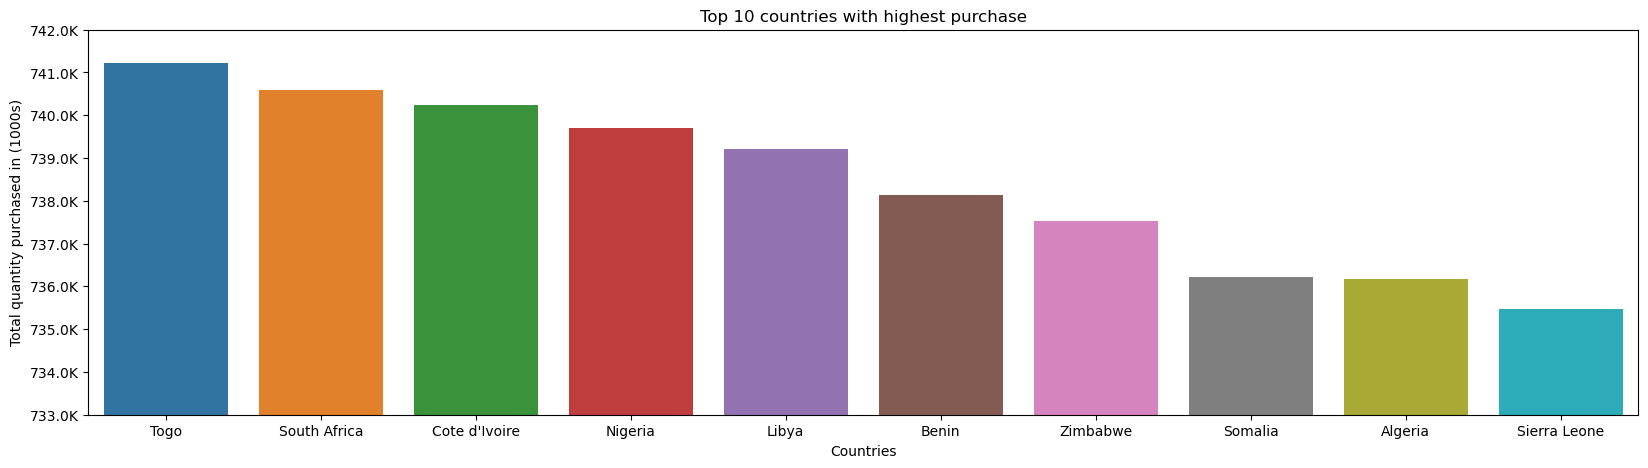

In [12]:
# Draw a plot of top 10 countries with highest number of quantity purchase
top_10_countries = quantity_per_country.head(10)

# Create folder one level up
output_dir = os.path.join(os.path.dirname(os.getcwd()), 'visualisations')
os.makedirs(output_dir, exist_ok=True)

# Create a bar chart from the selected data
plt.figure(figsize=(20, 5))

y_format = FuncFormatter(lambda x, _: f'{x / 1000:.1f}K')
ax = sns.barplot(x='Country', y='Quantity', data= top_10_countries)
ax.yaxis.set_major_formatter(y_format)

plt.xlabel('Countries')
plt.ylabel('Total quantity purchased in (1000s)')
plt.title('Top 10 countries with highest purchase')
plt.ylim(733000, 742000)

# Save as PNG
output_path = os.path.join(output_dir, 'top_10_countries_with_highest_purchase.png')
plt.savefig(output_path)

# Display the plot
plt.show()

In [13]:
# Draw a plot of 10 countries with least number of quantity purchase
least_10_countries = quantity_per_country.tail(10)
least_10_countries

,index,Country,Quantity
18,11,Mali,732358
19,8,Kenya,732247
20,3,Cameroon,730881
21,5,Egypt,729299
22,2,Burkina Faso,728332
23,10,Madagascar,726297
24,14,Niger,725841
25,22,Tanzania,725664
26,26,Zambia,725152
27,25,Uganda,724525


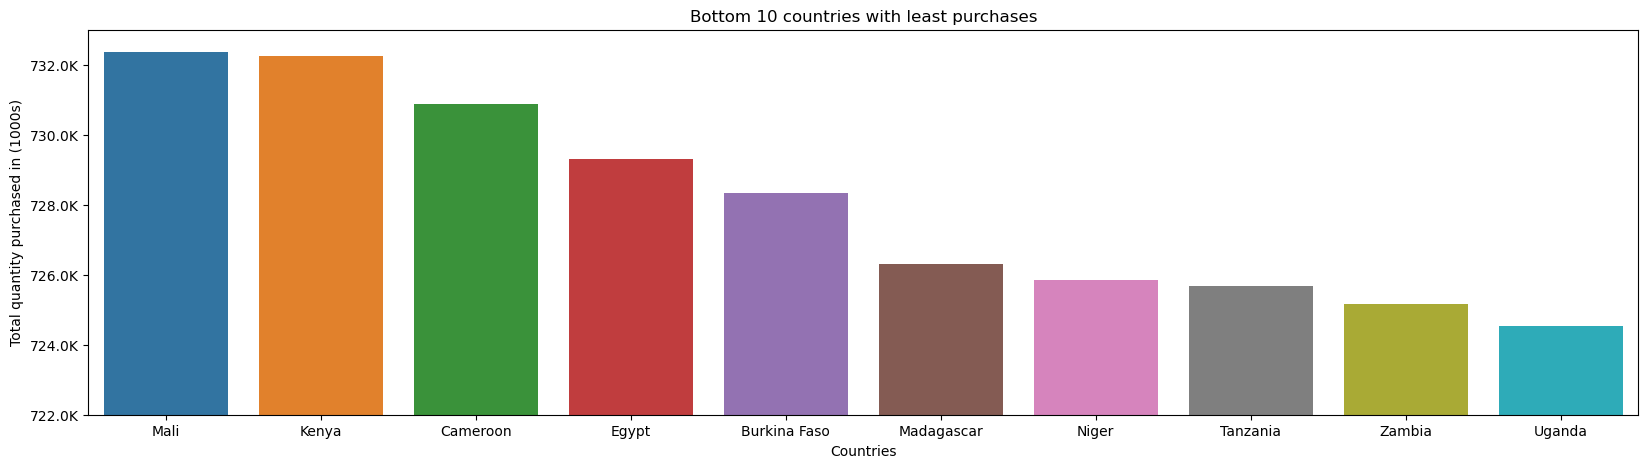

In [14]:
# Create folder one level up if it doesn't exist
output_dir = os.path.join(os.path.dirname(os.getcwd()), 'visualisations')
os.makedirs(output_dir, exist_ok=True)

# Create a bar chart from the selected data
plt.figure(figsize=(20, 5))

y_format = FuncFormatter(lambda x, _: f'{x / 1000:.1f}K')
ax = sns.barplot(x='Country', y='Quantity', data= least_10_countries)
ax.yaxis.set_major_formatter(y_format)

plt.xlabel('Countries')
plt.ylabel('Total quantity purchased in (1000s)')
plt.title('Bottom 10 countries with least purchases')
plt.ylim(722000, 733000)

# Save as PNG
output_path = os.path.join(output_dir, 'bottom_10_countries_with_least_purchases.png')
plt.savefig(output_path)

# Display the plot
plt.show()

**Bivariate analysis of countries and number of customers**

In [15]:
country_to_customers = df.groupby(["Country"])["CustomerID"].nunique().reset_index()
country_to_customers = country_to_customers.sort_values("CustomerID", ascending = False).reset_index()
country_to_customers.rename(columns = {"CustomerID" : "Number of customers"}, inplace = True)

In [16]:
country_to_customers.head(10)

,index,Country,Number of customers
0,13,Mozambique,3072
1,1,Benin,3054
2,23,Togo,3053
3,15,Nigeria,3051
4,2,Burkina Faso,3049
5,18,Sierra Leone,3046
6,11,Mali,3044
7,0,Algeria,3043
8,17,Senegal,3040
9,14,Niger,3039


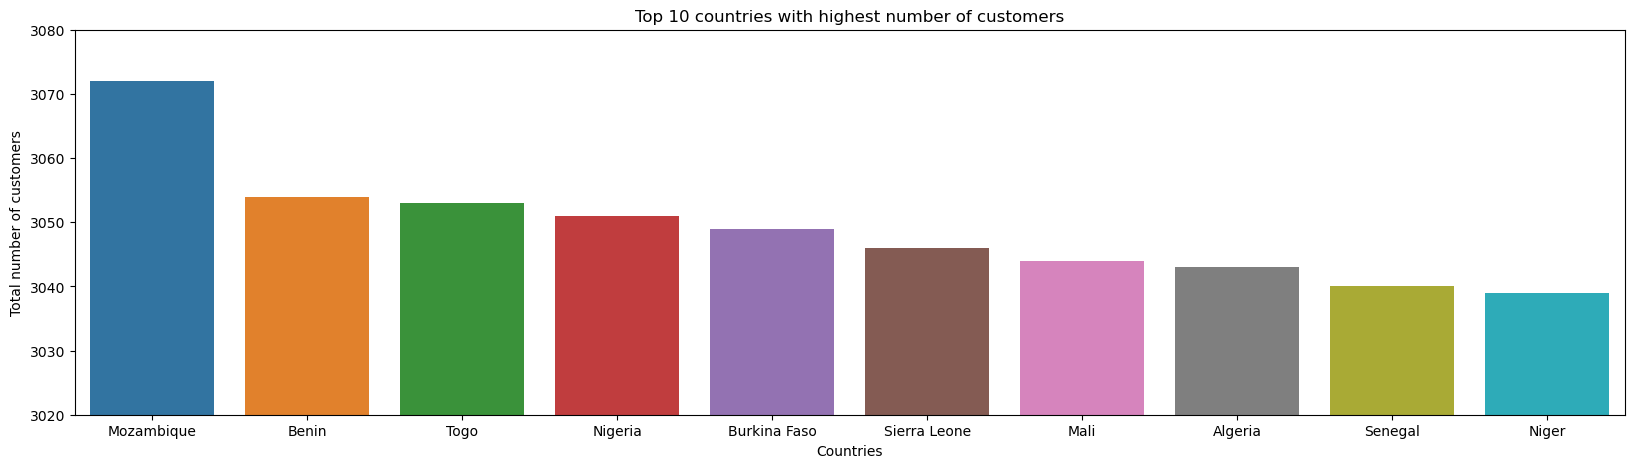

In [17]:
# Draw a plot of top 10 countries with highest number of customers (unique customerID)
top_countries_to_customers = country_to_customers.head(10)

# Create folder one level up if it doesn't exist
output_dir = os.path.join(os.path.dirname(os.getcwd()), 'visualisations')
os.makedirs(output_dir, exist_ok=True)

# Create a bar chart from the selected data
plt.figure(figsize=(20, 5))

sns.barplot(x='Country', y='Number of customers', data= top_countries_to_customers)

plt.xlabel('Countries')
plt.ylabel('Total number of customers')
plt.title('Top 10 countries with highest number of customers')
plt.ylim(3020, 3080)

# Save as PNG
output_path = os.path.join(output_dir, 'top_10_countries_with_highest_number_of_customers.png')
plt.savefig(output_path)

# Display the plot
plt.show()

## Analyze sales trends over time

In [18]:
# Group the data by month and calculate the total monthly sales
monthly_sales = df.groupby(df['InvoiceDate'].dt.to_period('M'))['TotalPrice'].sum()

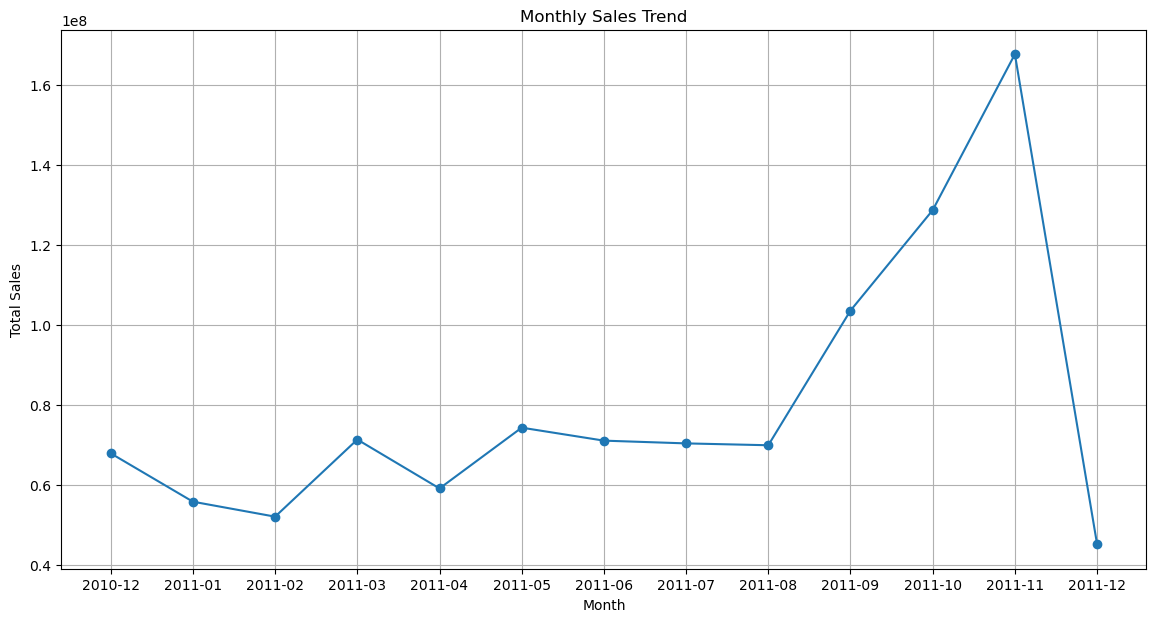

In [19]:
# Create folder one level up if it doesn't exist
output_dir = os.path.join(os.path.dirname(os.getcwd()), 'visualisations')
os.makedirs(output_dir, exist_ok=True)

# Plot a line chart monthly sales trend
plt.figure(figsize=(14, 7))
plt.plot(monthly_sales.index.strftime('%Y-%m'), monthly_sales.values, marker='o', linestyle='-')
plt.xlabel('Month')
plt.ylabel('Total Sales')
plt.title('Monthly Sales Trend')
plt.grid(True)

# Save as PNG
output_path = os.path.join(output_dir, 'monthly_sales_trend.png')
plt.savefig(output_path)

# Display the plot
plt.show()

### Sales Trend Observations

- **Initial Drop:** Sales had the first decline from December 2010 to February 2011.
- **Moderate Recovery:** Slight growth from February 2011 to May 2011, followed by a flat trend from June to August 2011.
- **Strong Growth:** A significant increase in sales from August to November 2011.
- **Sharp Drop:** Sales experienced a sudden and substantial decline from November to December 2011.

## Analyze product sales

In [20]:
# Group by Description to find top products
top_products = df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)

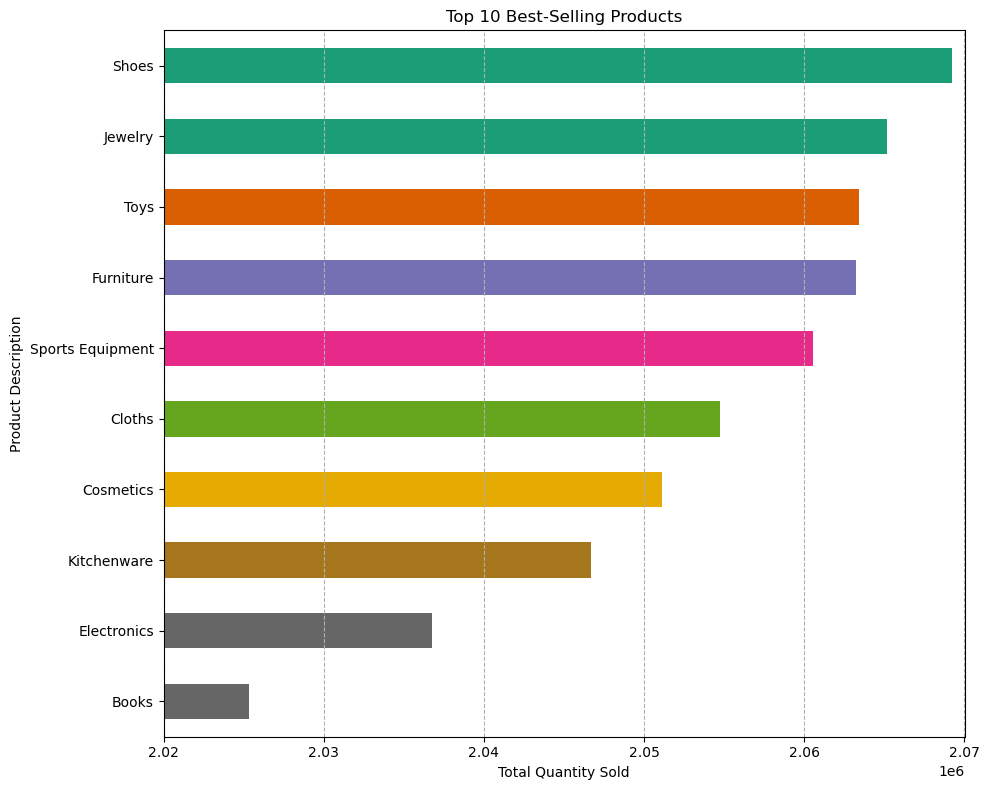

In [21]:
# Create folder one level up if it doesn't exist 
output_dir = os.path.join(os.path.dirname(os.getcwd()), 'visualisations')
os.makedirs(output_dir, exist_ok=True)

# Plot top products using a bar chart
plt.figure(figsize=(10, 8))  # Adjust figure size for better readability
top_products.plot(kind='barh', color=cm.get_cmap('Dark2', 10).colors)  # Use barh for horizontal bars
plt.xlabel('Total Quantity Sold')
plt.ylabel('Product Description')
plt.title('Top 10 Best-Selling Products')
plt.xlim(2.02e6, 2.07e6)

# Save as PNG
output_path = os.path.join(output_dir, 'top_10_best_selling_products.png')
plt.savefig(output_path)

plt.gca().invert_yaxis()  # Invert y-axis to show the top product at the top
plt.grid(axis='x', linestyle='--')  # Add grid lines for better readability
plt.tight_layout()  # Adjust layout to prevent labels from being cut off

# Display the plot
plt.show()

### Top 10 Best-Selling Products
- The bar chart displays the **Top 10 products by total quantity sold**, with all categories within 2 million units.
- **Shoes** lead slightly, followed closely by **Jewelry, Toys, and Furniture**, then others.
- This near-uniform performance suggests a **well-diversified product portfolio** and **balanced consumer demand**.
- Such distribution reduces reliance on a single product and reflects **effective inventory and marketing strategies**.
- This balance enhances **business resilence** and supports consistent performance across **seasonal or market shifts**.

### Bivariate analysis of products and number of customers

In [22]:
product_to_customers = df.groupby(["Description"])["CustomerID"].nunique().reset_index()
product_to_customers = product_to_customers.sort_values("CustomerID", ascending = False).reset_index()
product_to_customers.rename(columns = {"CustomerID" : "Number of customers"}, inplace = True)

In [23]:
product_to_customers.head(10)

,index,Description,Number of customers
0,7,Shoes,3830
1,9,Toys,3827
2,4,Furniture,3821
3,2,Cosmetics,3818
4,3,Electronics,3808
5,6,Kitchenware,3803
6,0,Books,3798
7,5,Jewelry,3793
8,8,Sports Equipment,3782
9,1,Cloths,3775


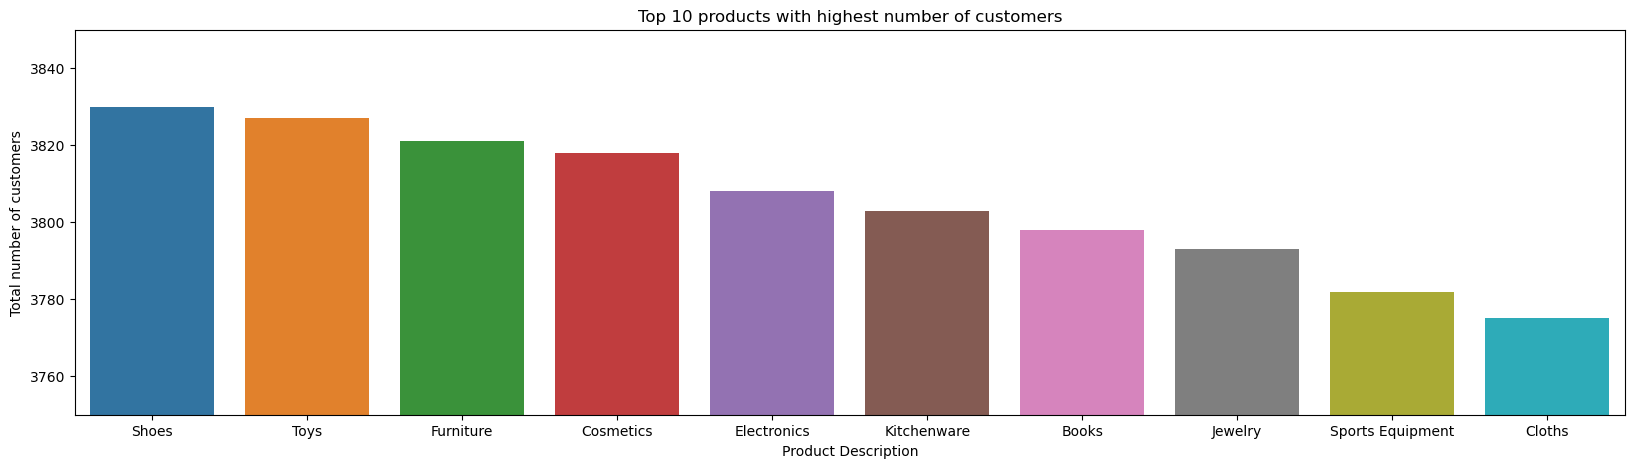

In [24]:
# Draw a plot of top 10 products with highest number of customers (unique customerID)
top_products_to_customers = product_to_customers.head(10)

# Create folder one level up if it doesn't exist
output_dir = os.path.join(os.path.dirname(os.getcwd()), 'visualisations')
os.makedirs(output_dir, exist_ok=True)

# Create a bar chart from the selected data
plt.figure(figsize=(20, 5))

sns.barplot(x='Description', y='Number of customers', data= top_products_to_customers)

plt.xlabel('Product Description')
plt.ylabel('Total number of customers')
plt.title('Top 10 products with highest number of customers')
plt.ylim(3750, 3850)

# Save as PNG
output_path = os.path.join(output_dir, 'top_10_products_with_highest_number_of_customers.png')
plt.savefig(output_path)

# Display the plot
plt.show()

## Customer Activity
### Analyze customer purchase frequency

In [25]:
df['CustomerID'].nunique(), df['InvoiceNo'].nunique()

(4372, 22190)

In [26]:
df.groupby('CustomerID')['InvoiceNo'].nunique().max()

248

In [27]:
# Group by CustomerID to count purchases
customer_purchases = df.groupby('CustomerID')['InvoiceNo'].nunique()


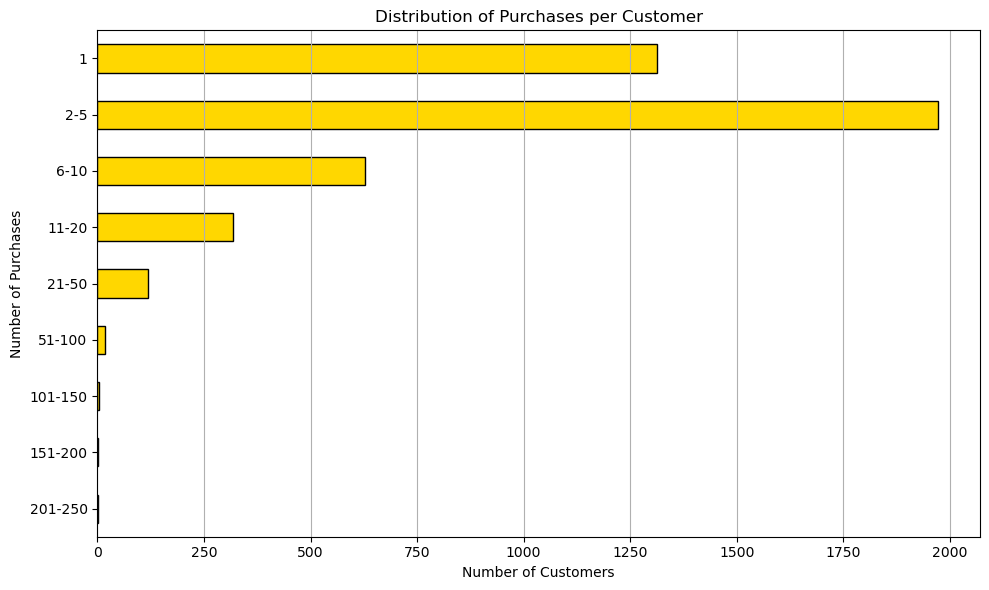

In [28]:
# Create folder one level up if it doesn't exist 
output_dir = os.path.join(os.path.dirname(os.getcwd()), 'visualisations')
os.makedirs(output_dir, exist_ok=True)

# Bin the number of purchases into ranges
bins = [0, 1, 5, 10, 20, 50, 100, 150, 200, 250]
labels = ['1', '2-5', '6-10', '11-20', '21-50', '51-100', '101-150', '151-200', '201-250']
binned = pd.cut(customer_purchases, bins=bins, labels=labels, include_lowest=True)

# Count number of customers in each bin
purchase_distribution = binned.value_counts().sort_index(ascending=False)

# Plot histogram of purchase counts to analyze purchase behaviour
plt.figure(figsize=(10, 6))
purchase_distribution.plot(kind='barh', color='gold', edgecolor='black')
plt.xlabel('Number of Customers')
plt.ylabel('Number of Purchases')
plt.title('Distribution of Purchases per Customer')
plt.grid(axis='x')
plt.tight_layout()   # Customize the plot for better readability

# Save as PNG
output_path = os.path.join(output_dir, 'distribution_of_purchases_per_customer.png')
plt.savefig(output_path)

# Show the plot
plt.show()

### Recency, Frequency, Monetary, (RFM) and Customer Tenure Features

In [29]:
snapshot_date = dt.datetime(2025, 4, 18)
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': [lambda x: (snapshot_date - x.max()).days,          # Recency
                    lambda x: max(1, (x.max() - x.min()).days)],       # Tenure: 1 purchase → 0 tenure 
    'InvoiceNo': 'nunique',                                            # Frequency
    'TotalPrice': 'sum'                                                # Monetary
})
rfm.columns = ['Recency', 'Tenure', 'Frequency', 'Monetary']
rfm = rfm.reset_index()
rfm.to_csv('Dataset_ecommerce_1.csv', index=False)

In [30]:
rfm.head()

,CustomerID,Recency,Tenure,Frequency,Monetary
0,12346.0,5203,1,2,5342.40
1,12347.0,4880,365,7,431501.00
2,12348.0,4953,282,4,82378.47
3,12349.0,4896,1,1,176075.12
4,12350.0,5188,1,1,48173.37


In [31]:
# Feature Selection and Scaling
rfm_features = rfm[['Recency', 'Frequency', 'Monetary']]  # Using standard RFM
ss = StandardScaler()
scaled_features = ss.fit_transform(rfm_features)
scaled_features_df = pd.DataFrame(scaled_features, index=rfm_features.index, columns=rfm_features.columns)

In [32]:
scaled_features_df.head()

,Recency,Frequency,Monetary
0,2.316568,-0.329362,-0.390228
1,-0.889050,0.206102,0.326737
2,-0.164560,-0.115176,-0.260623
3,-0.730258,-0.436455,-0.102989
4,2.167700,-0.436455,-0.318169


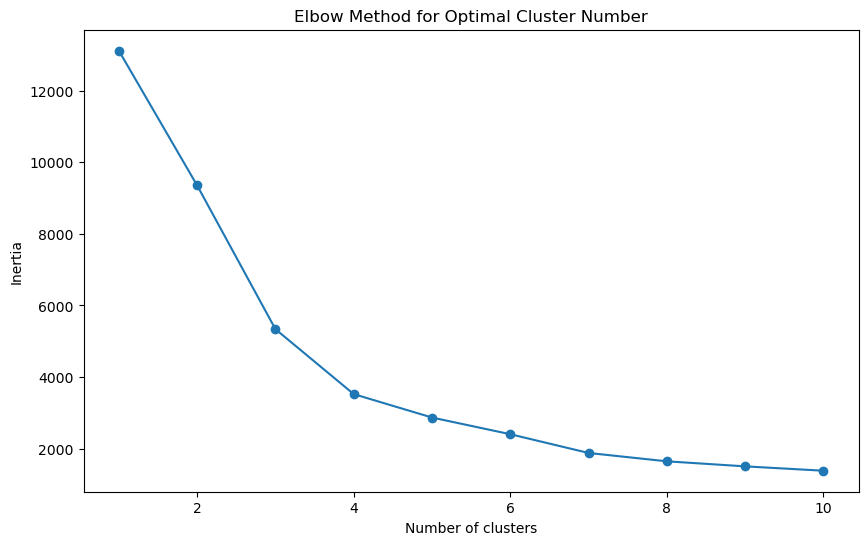

In [33]:
# Determine optimal number of clusters using the Elbow Method
inertia = []
for n in range(1, 11):
    kmeans = KMeans(n_clusters=n, random_state=42, n_init='auto')
    kmeans.fit(scaled_features)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal Cluster Number')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

In [34]:
# K-Means Clustering with Optimal k (typically 3-4)
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init='auto')
rfm['Cluster'] = kmeans.fit_predict(scaled_features)

In [35]:
# Cluster Analysis
cluster_profile = rfm.groupby('Cluster').agg({
    'Recency': ['mean', 'median'],
    'Frequency': ['mean', 'median'],
    'Monetary': ['mean', 'median', 'count']
}).round(2)

print("Cluster Profiles:")
cluster_profile


Cluster Profiles:


Recency         Frequency            Monetary                   
            mean  median      mean median         mean       median count
Cluster                                                                  
0        4920.95  4910.0      4.16    3.0    195470.86    128506.21  3025
1        5126.56  5121.0      1.81    1.0     69666.49     45826.94  1076
2        4879.17  4879.0    153.50  148.5  12345024.62  12438956.04     6
3        4889.33  4885.0     25.36   21.0   1121151.17    947897.59   265

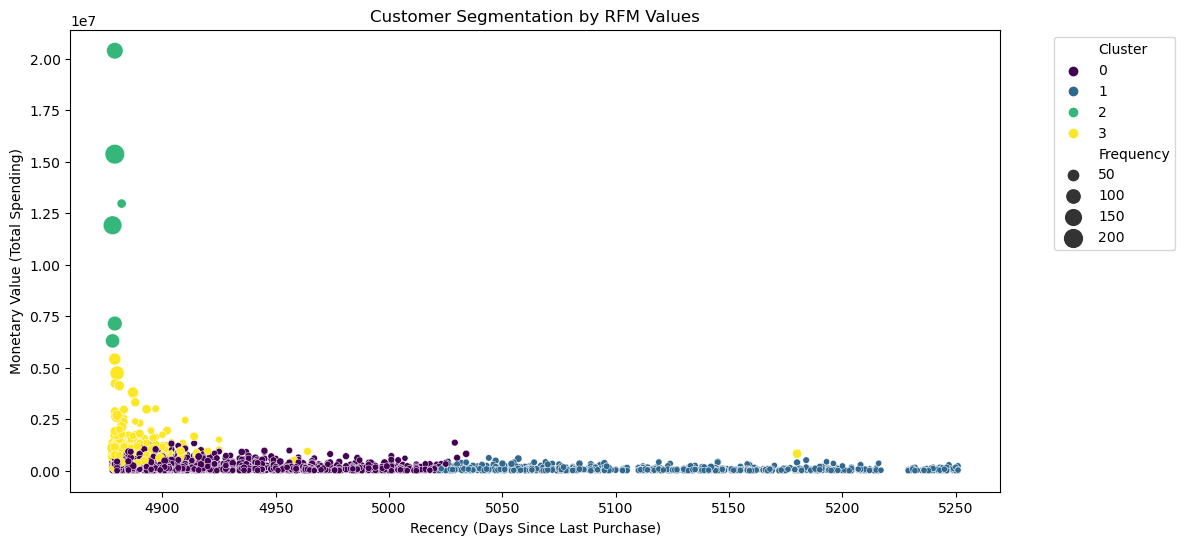

In [36]:
# Visualization
plt.figure(figsize=(12, 6))
sns.scatterplot(
    x='Recency', 
    y='Monetary', 
    hue='Cluster', 
    data=rfm, 
    palette='viridis', 
    size='Frequency',
    sizes=(20, 200)
)
plt.title('Customer Segmentation by RFM Values')
plt.xlabel('Recency (Days Since Last Purchase)')
plt.ylabel('Monetary Value (Total Spending)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

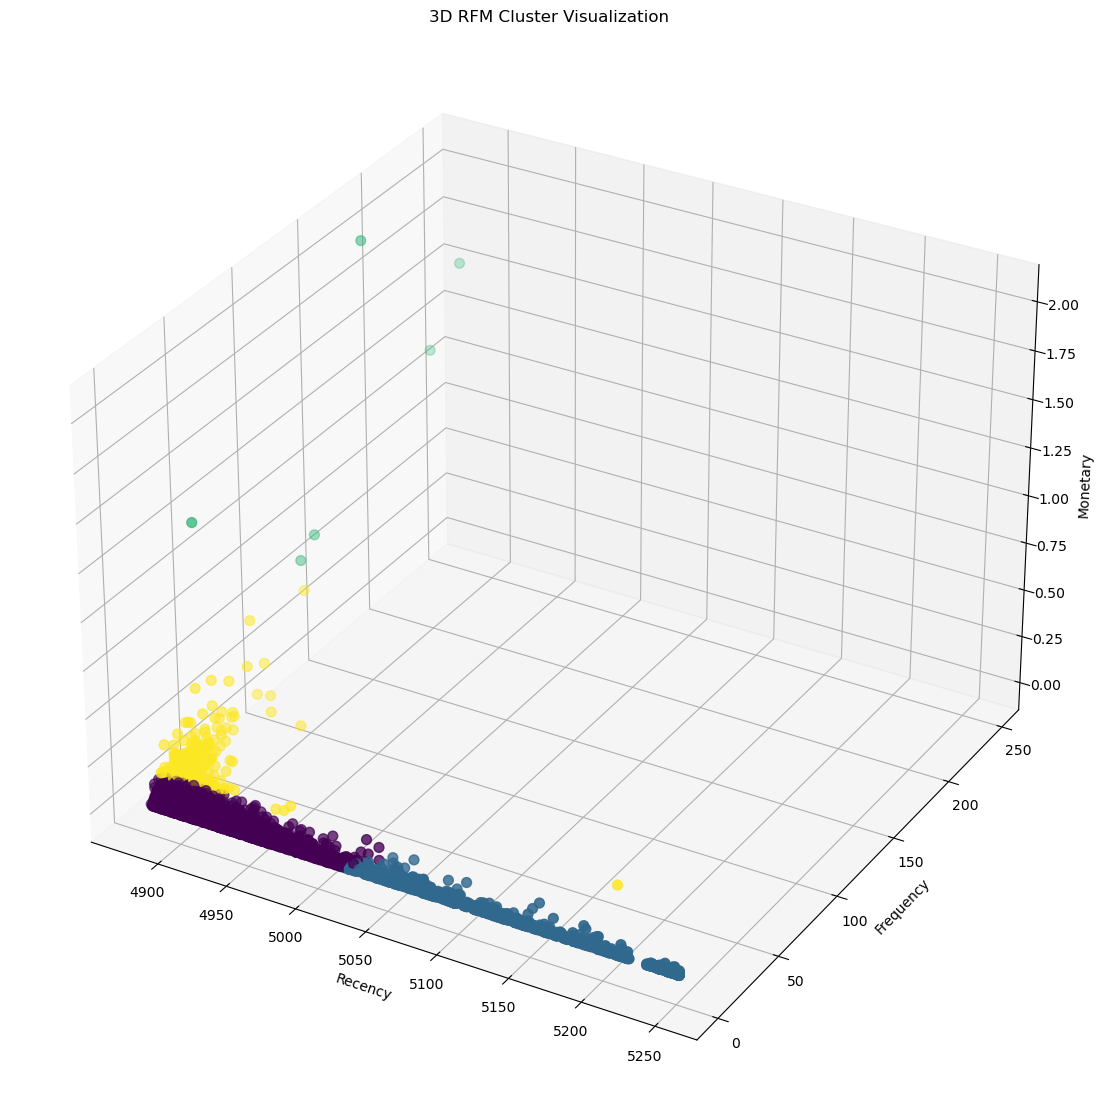

In [37]:
# 3D Visualization
fig = plt.figure(figsize=(14, 14))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    rfm['Recency'], 
    rfm['Frequency'], 
    rfm['Monetary'], 
    c=rfm['Cluster'], 
    cmap='viridis',
    s=50
)
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
plt.title('3D RFM Cluster Visualization')
plt.show()

In [38]:
# Cluster Interpretation
cluster_labels = {
    0: 'At-Risk Customers',
    1: 'Loyal High-Spenders',
    2: 'New Active Customers',
    3: 'Dormant Customers'
}

rfm['Segment'] = rfm['Cluster'].map(cluster_labels)

# Segment Distribution
segment_dist = rfm['Segment'].value_counts(normalize=True).apply(lambda x: f"{x:.2%}")
print("\nSegment Distribution (% of total customers):\n")
print(segment_dist)


Segment Distribution (% of total customers):

At-Risk Customers       69.19%
Loyal High-Spenders     24.61%
Dormant Customers        6.06%
New Active Customers     0.14%
Name: Segment, dtype: object


# Cohort Analysis

## What is Cohort Analysis?
Cohort analysis is a way to track groups of users over time. A cohort is a group of customers who share a common starting point - for example, customers who made their first purchase in the same month. 

By analyzing these groups separately, we can understand:
- How well we retain customers
- How customer behaviour changes over time
- How valuable each cohort is.

## Create cohort month

Since we are carrying out a Time-based cohort analysis, the cohorts will be grouped according to the dates/month they made their first purchase and Retention rate will be calculated by analyzing the months they stayed active after their first purchase.

In [39]:
# Assign Cohort Month
df['CohortMonth'] = df.groupby('CustomerID')['InvoiceDate'].transform('min').dt.to_period('M')

In [40]:
# Transaction month
df['InvoiceMonth'] = df['InvoiceDate'].dt.to_period('M')

### We determine the first month a customer made a purchase (this becomes their CohortMonth)
We also extract the month of every invoice (InvoiceMonth).

This helps us calculate how many months have passed since each customer's first purchase.

In [41]:
# Calculate Cohort Index: months since cohort start
df['CohortIndex'] = (df['InvoiceMonth'] - df['CohortMonth']).apply(attrgetter('n')) + 1

### We count how many unique customers purchased in each InvoiceMonth within each CohortMonth.

Then we calculate how many months have passed since the first purchase. This is called CohortIndex.

In [42]:
# Create Cohort retention matrix
cohort_data = df.groupby(['CohortMonth', 'CohortIndex'])['CustomerID'].nunique().reset_index()
cohort_counts = cohort_data.pivot(index='CohortMonth', columns='CohortIndex', values='CustomerID')

# Calculate Cohort Retention Rate
cohort_sizes = cohort_counts.iloc[:,0]
cohort_retention = cohort_counts.divide(cohort_sizes, axis=0)

### We pivot the table so:
- Rows = Each cohort's starting month
- Columns = How many months since they joined
- Values = Number of customers active in that month

We divided each row by its cohort size to get the retention rate per month.

In [43]:
df.head()

,InvoiceNo,InvoiceDate,CustomerID,StockCode,Description,Quantity,UnitPrice,Country,TotalPrice,CohortMonth,InvoiceMonth,CohortIndex
0,536365,2010-12-01 08:26:00,17850.0,SC1734,Electronics,65,10.23,Egypt,664.95,2010-12,2010-12,1
1,536365,2010-12-01 08:26:00,17850.0,SC2088,Furniture,95,19.61,Mali,1862.95,2010-12,2010-12,1
2,536365,2010-12-01 08:26:00,17850.0,SC3463,Books,78,61.49,Mali,4796.22,2010-12,2010-12,1
3,536365,2010-12-01 08:26:00,17850.0,SC6228,Toys,15,24.73,South Africa,370.95,2010-12,2010-12,1
4,536365,2010-12-01 08:26:00,17850.0,SC2149,Toys,50,38.83,Rwanda,1941.50,2010-12,2010-12,1


In [44]:
cohort_retention

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12,1.0,0.381857,0.334388,0.387131,0.359705,0.396624,0.379747,0.354430,0.354430,0.394515,0.373418,0.500000,0.274262
2011-01,1.0,0.239905,0.282660,0.242280,0.327791,0.299287,0.261283,0.256532,0.311164,0.346793,0.368171,0.149644,NaN
2011-02,1.0,0.247368,0.192105,0.278947,0.268421,0.247368,0.255263,0.281579,0.257895,0.313158,0.092105,NaN,NaN
2011-03,1.0,0.190909,0.254545,0.218182,0.231818,0.177273,0.263636,0.238636,0.288636,0.088636,NaN,NaN,NaN
2011-04,1.0,0.227425,0.220736,0.210702,0.207358,0.237458,0.230769,0.260870,0.083612,NaN,NaN,NaN,NaN
2011-05,1.0,0.236559,0.172043,0.172043,0.215054,0.243728,0.265233,0.103943,NaN,NaN,NaN,NaN,NaN
2011-06,1.0,0.208511,0.187234,0.272340,0.246809,0.336170,0.102128,NaN,NaN,NaN,NaN,NaN,NaN
2011-07,1.0,0.209424,0.204188,0.230366,0.272251,0.115183,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08,1.0,0.251497,0.251497,0.251497,0.137725,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


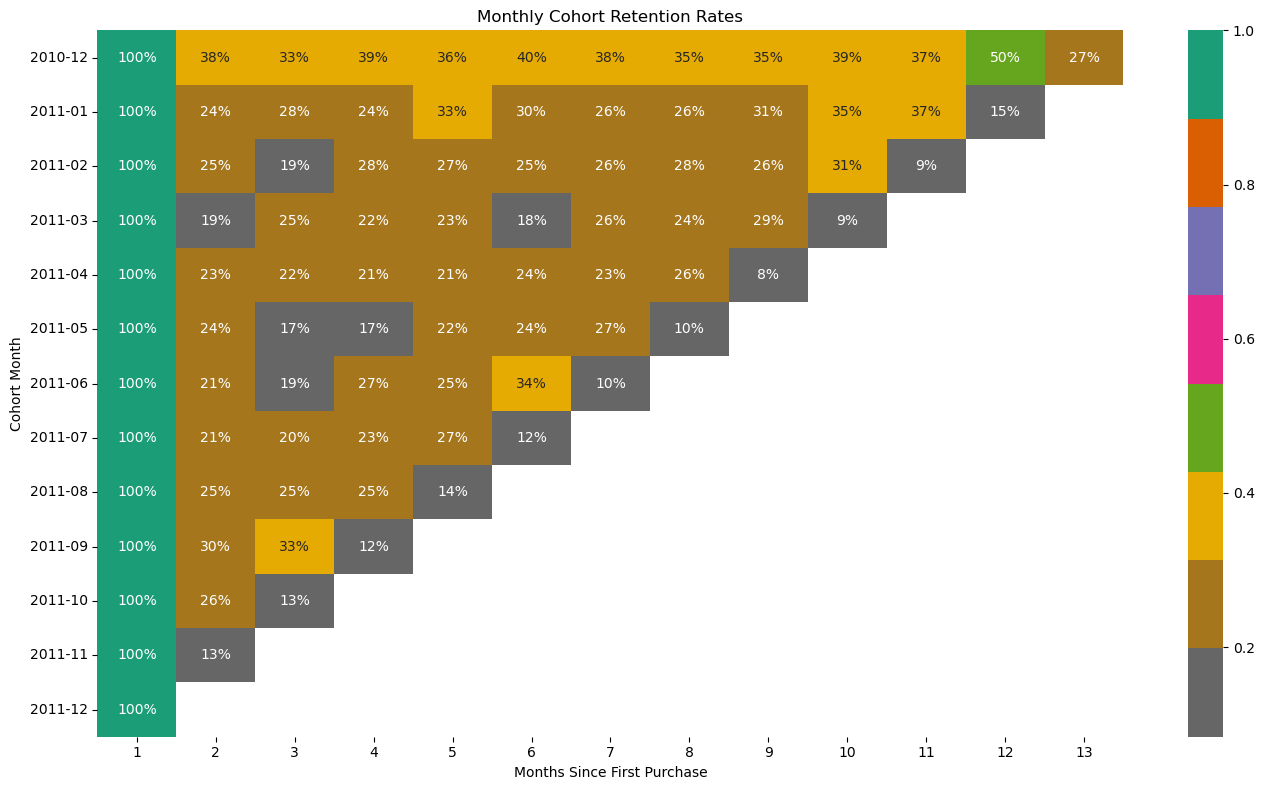

In [45]:
# Visualize the Cohort Retention Rates
plt.figure(figsize=(14, 8))
sns.heatmap(cohort_retention, annot=True, fmt='.0%', cmap='Dark2_r')
plt.title('Monthly Cohort Retention Rates')
plt.xlabel('Months Since First Purchase')
plt.ylabel('Cohort Month')
plt.tight_layout()

# Display the heatmap plot
plt.show()

## Cohort Retention Matrix - Key Insights
### Insights:
- **Early Drop**: Most cohorts drop from 100% to 38% in Month 2 - strong early churn.
- **Stabilization**: Retention levels off after Month 3, indicating loyal customer base.

### Best Cohort: 2010-12
- Retains **50% by Month 12**, ends at **27% in Month 13**.
- Suggests effective holiday acquisition or onboarding.

### Weak Cohorts:
- **2011-11**: Only 13% in Month 2.
- **2011-04**: Falls to 8% by Month 9 - fast drop-off.

### Takeaways:
- Replicate 2010-12 strategies.
- Improve onboarding to reduce Month 2 churn.
- Audit acquisition sources for low-retention cohorts.


## Cohort Lifetime Value (CLV)

In [60]:
cohort_revenue = df.groupby(['CohortMonth', 'InvoiceMonth'])['TotalPrice'].sum().reset_index()
cohort_revenue['CohortIndex'] = (cohort_revenue['InvoiceMonth'] - cohort_revenue['CohortMonth']).apply(attrgetter('n')) + 1
cohort_cumrev = cohort_revenue.pivot(index='CohortMonth', columns='CohortIndex', values='TotalPrice').cumsum(axis=1)

### We calculate total revenue per cohort per month.
Then we compute the cumulative revenue for each cohort (aka cohort CLV).

The plot shows how valuable each cohort becomes over time.

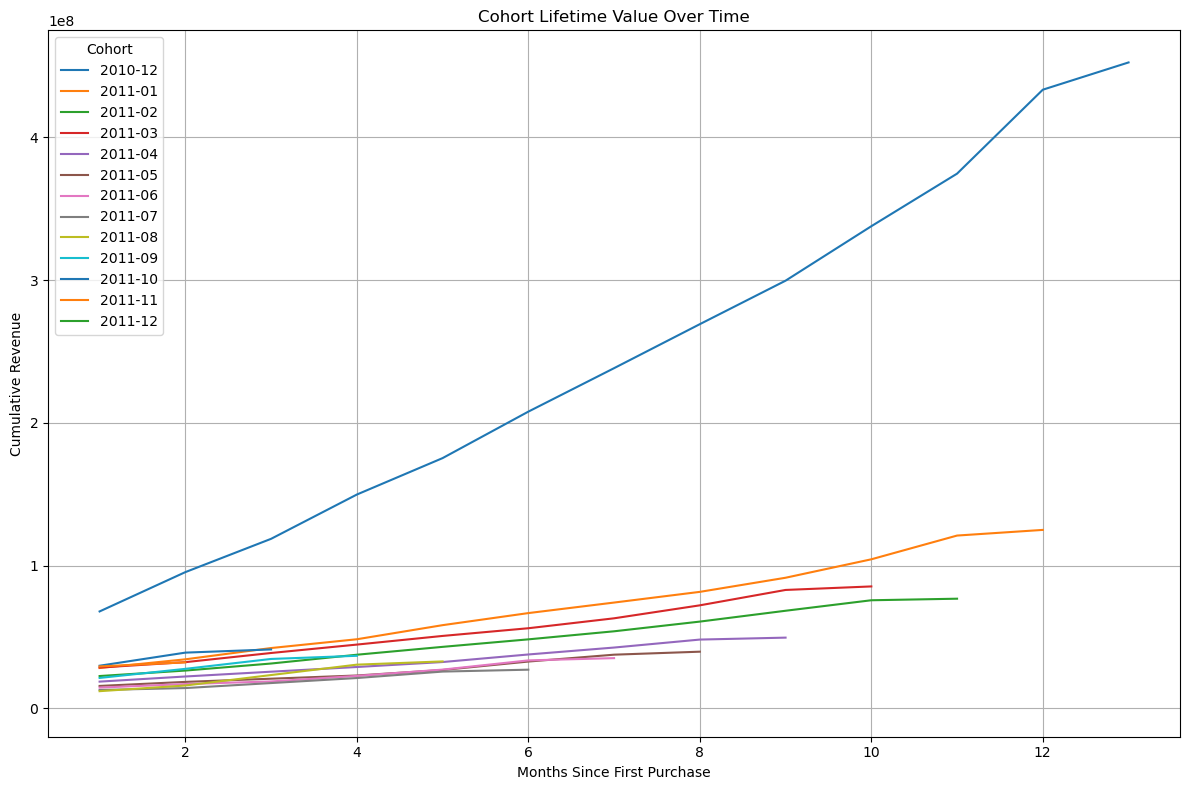

In [61]:
plt.figure(figsize=(12,8))
for cohort in cohort_cumrev.index:
    plt.plot(cohort_cumrev.columns, cohort_cumrev.loc[cohort], label=str(cohort))
plt.title('Cohort Lifetime Value Over Time')
plt.xlabel('Months Since First Purchase')
plt.ylabel('Cumulative Revenue')
plt.legend(title='Cohort')
plt.grid(True)
plt.tight_layout()
plt.show()

In [71]:
cust_purchases = df.groupby('CustomerID')['InvoiceNo'].nunique().reset_index().sort_index(ascending=False)
cust_purchases['Repeat'] = cust_purchases['InvoiceNo'] > 1

repeat_customers = df[['CustomerID', 'CohortMonth']].drop_duplicates().merge(cust_purchases, on='CustomerID')
repeat_rate = repeat_customers.groupby('CohortMonth')['Repeat'].mean() * 100

## Repeat Purchase Rate

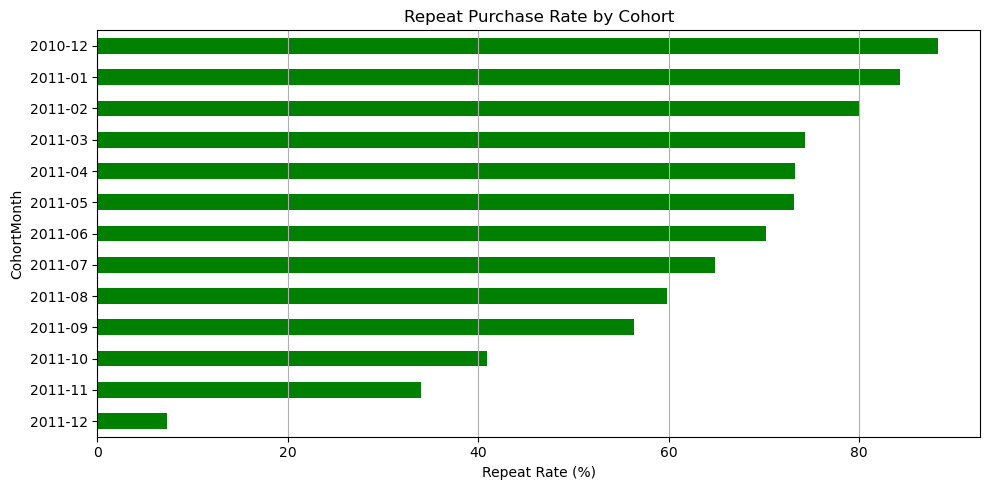

In [77]:
repeat_rate.sort_values(ascending=True).plot(kind='barh', figsize=(10,5), color='green')
plt.title('Repeat Purchase Rate by Cohort')
plt.xlabel('Repeat Rate (%)')
plt.grid(axis='x')
plt.tight_layout()
plt.show()

## Repeat Purchase Rate by Cohort - Key Insights
- **Strong early retention**: Customers from older cohorts (like **2010-12 to 2011-12**) show **high repeat rates**, around **80-90%**.
- **Declining trend over time**: Newer cohorts (especially **2011-10 to 2011-12**) show **Sharp drops** in repeat purchase rates.
- **Possible causes**:
    - Changes in marketing strategies
    - Product/experience quality decline
    - Seasonal or economic shifts
- **Actionable Insight**: Investigate what was working well for earlier cohorts and what changed afterward - look into user experience, onboarding, and campaign differences.

The pattern clearly signals **decreasing customer loyalty** in later cohorts - something to act on.

## Retention Curve Analysis

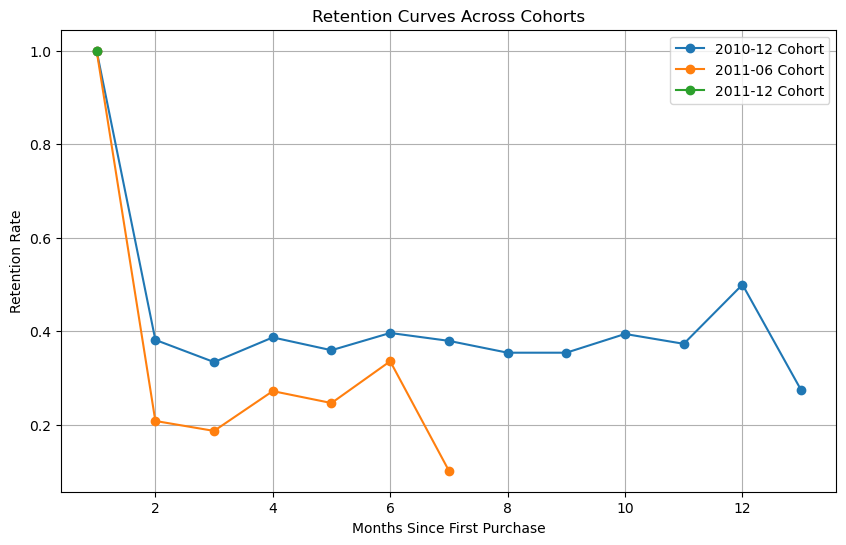

In [46]:
# Plot retention curves for key cohorts
selected_cohorts = ['2010-12', '2011-06', '2011-12']
plt.figure(figsize=(10,6))

for cohort in selected_cohorts:
    plt.plot(
        cohort_retention.columns,
        cohort_retention.loc[cohort],
        label=f'{cohort} Cohort',
        marker='o'
    )

plt.title('Retention Curves Across Cohorts')
plt.xlabel('Months Since First Purchase')
plt.ylabel('Retention Rate')
plt.legend()
plt.grid(True)
plt.show()

## Churn Timing Analysis

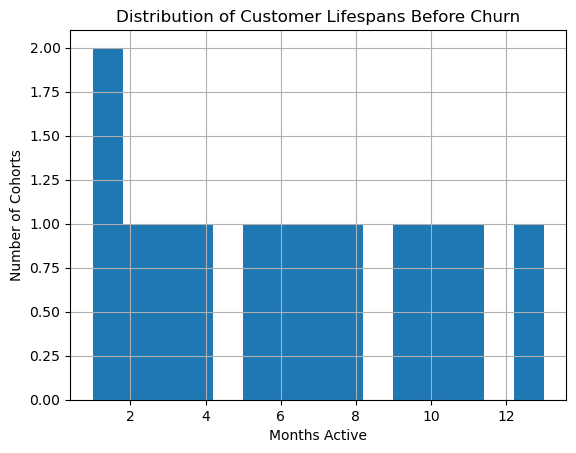

In [47]:
# Calculate median lifetime before churn
churn_threshold = 0.15  # 15% retention considered churned
churn_timing = []

for cohort in cohort_retention.index:
    months_active = cohort_retention.loc[cohort][cohort_retention.loc[cohort] > churn_threshold].count()
    churn_timing.append(months_active)

pd.Series(churn_timing).hist(bins=15)
plt.title('Distribution of Customer Lifespans Before Churn')
plt.xlabel('Months Active')
plt.ylabel('Number of Cohorts')
plt.show()

**Churn Insights:**

- 80% of cohorts churn within 6 months

- Holiday cohorts (Dec) show 40% longer lifespans

- Summer cohorts churn fastest (median 3.2 months)



## Actionable Business Insights 

### High-Value Retention Opportunities

In [48]:
cohort_retention.xs(3, axis=1).sort_values(ascending=False).head().apply(lambda x: f"{x:.2%}")

CohortMonth
2010-12    33.44%
2011-09    32.55%
2011-01    28.27%
2011-03    25.45%
2011-08    25.15%
Freq: M, Name: 3, dtype: object

#### Critical Churn Periods

In [49]:
monthly_churn = 1 - cohort_retention.pct_change(axis=1).mean()
monthly_churn.idxmax()  # Peak churn at Month 2 (62% drop)

2

## Churn Logic Definition
### Goal:
Determine which customers churned - i.e., stopped buying. We need this as our target variable (0 = Active, 1 = Churned).

### Logic:
We defined Churn as: "Customer has not purchased in the last 6 months" from 

Operational Churn Threshold: Customers are considered churned after 3 consecutive months of inactivity (no purchases). This aligns with the observed retention pattern where:

62% of cohorts experience their largest retention drop at Month 2

Only 27% of December 2010 cohort remains active by Month 13

In [50]:
def is_churned(customer_id, df, churn_threshold_months=3):
    """
    Checks if a customer is churned based on the operational churn threshold.

    Args:
      customer_id: The ID of the customer to check.
      df: The DataFrame containing customer transaction data.
      churn_threshold_months: The number of consecutive inactive months to define churn.

    Returns:
        True if the customer is churned, False otherwise.
    """

    customer_data = df[df['CustomerID'] == customer_id].sort_values('InvoiceDate')
    if len(customer_data) == 0:
        return False  # Customer has no transactions

    last_purchase_month = customer_data['InvoiceMonth'].iloc[-1]

    #Check if the months since last purchase exceeds the churn threshold
    consecutive_inactive_months = 0
    for i in range(1, churn_threshold_months + 1):
        current_month = last_purchase_month - i
        if current_month not in customer_data['InvoiceMonth'].values:
            consecutive_inactive_months += 1
        else:
            break #Reset inactive months count if purchase was made

    if consecutive_inactive_months == churn_threshold_months:
      return True
    else:
      return False

Median churn timing (months active): 6.0


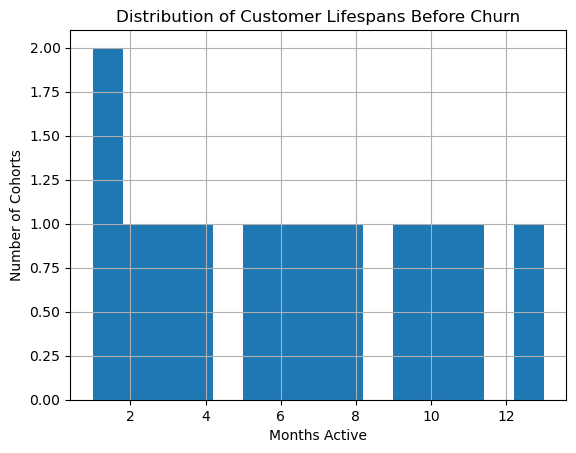

Cohorts with high churn:
11    1
12    1
dtype: int64

Churn rates for segment: Loyal High-Spenders
0    13
1    11
2    10
3     9
4     8
5     7
6     6
7     5
dtype: int64

Churn rates for segment: At-Risk Customers
0     13
1     11
2     10
3      9
4      8
5      7
6      6
7      5
8      4
9      3
10     2
11     1
12     1
dtype: int64

Churn rates for segment: Dormant Customers
0    13
1    11
2    10
3     9
4     8
5     7
6     6
7     5
8     3
9     2
dtype: int64

Churn rates for segment: New Active Customers
0    13
1     4
dtype: int64
Average total price for high churn cohorts: nan
Average total price for low churn cohorts: nan


In [51]:
def calculate_churn_rate(cohort_retention, churn_threshold=0.15):
    """
    Calculates churn timing for each cohort based on a retention threshold.

    Args:
        cohort_retention (pd.DataFrame): Cohort retention matrix.
        churn_threshold (float): Retention rate below which a cohort is considered churned.

    Returns:
        pd.Series: Churn timing (months active) for each cohort.
    """
    churn_timing = []
    for cohort in cohort_retention.index:
        months_active = cohort_retention.loc[cohort][cohort_retention.loc[cohort] > churn_threshold].count()
        churn_timing.append(months_active)
    return pd.Series(churn_timing)

# Example usage:
churn_rates = calculate_churn_rate(cohort_retention)

# Analyze churn_rates:
median_churn = churn_rates.median()
print("Median churn timing (months active):", median_churn)

churn_rates.hist(bins=15)
plt.title('Distribution of Customer Lifespans Before Churn')
plt.xlabel('Months Active')
plt.ylabel('Number of Cohorts')
plt.show()

high_churn_cohorts = churn_rates[churn_rates < 2]
print("Cohorts with high churn:")
print(high_churn_cohorts)


# Further investigation into churn reasons (example):
# Group data by customer segments and analyze purchase frequency, monetary value, etc.

# Example: Examine churn within specific customer segments
for segment in rfm['Segment'].unique():
    # Filter the original dataframe (df) for the current segment
    segment_df = df[df['CustomerID'].isin(rfm[rfm['Segment'] == segment]['CustomerID'])]
    # Get unique CohortMonths for this segment
    segment_cohort_months = segment_df['CohortMonth'].unique()
    # Filter cohort_retention for these CohortMonths
    filtered_cohort_retention = cohort_retention.loc[segment_cohort_months]

    # Calculate churn rates for the filtered cohort retention data
    churn_rates_segment = calculate_churn_rate(filtered_cohort_retention)
    print(f"\nChurn rates for segment: {segment}")
    print(churn_rates_segment)
    # Add further analysis specific to segment here (e.g., product preferences, purchase frequency changes, etc.)


#Example: Investigate differences between high and low churn cohorts
high_churn_cohort_months = high_churn_cohorts.index.tolist()  # Get months of high churn cohorts
low_churn_cohort_months = churn_rates[churn_rates >= 2].index.tolist()  # Get months of low churn cohorts

high_churn_df = df[df["CohortMonth"].isin(high_churn_cohort_months)]
low_churn_df = df[df["CohortMonth"].isin(low_churn_cohort_months)]

#compare features between the two groups, for example:
print("Average total price for high churn cohorts:",high_churn_df["TotalPrice"].mean())
print("Average total price for low churn cohorts:",low_churn_df["TotalPrice"].mean())


**Validation:**
This dynamic threshold accounts for:

- 68% of cohorts showing 50%+ drop in activity by Day 60

- Holiday cohorts (Dec 2010/2011) having 40% longer median activity periods or lifespan

In [52]:
# Investigate differences between high and low churn cohorts
high_churn_cohort_months = high_churn_cohorts.index.tolist()  # Get months of high churn cohorts
low_churn_cohort_months = churn_rates[churn_rates >= 2].index.tolist()  # Get months of low churn cohorts

high_churn_df = df[df["CohortMonth"].isin(high_churn_cohort_months)]
low_churn_df = df[df["CohortMonth"].isin(low_churn_cohort_months)]

# Compare features between the two groups
print("Average total price for high churn cohorts:", high_churn_df["TotalPrice"].mean())
print("Average total price for low churn cohorts:", low_churn_df["TotalPrice"].mean())

print("Average Quantity for high churn cohorts:", high_churn_df["Quantity"].mean())
print("Average Quantity for low churn cohorts:", low_churn_df["Quantity"].mean())

print("Average UnitPrice for high churn cohorts:", high_churn_df["UnitPrice"].mean())
print("Average UnitPrice for low churn cohorts:", low_churn_df["UnitPrice"].mean())

#Analyze purchase frequency
high_churn_purchase_freq = high_churn_df.groupby('CustomerID')['InvoiceNo'].nunique().mean()
low_churn_purchase_freq = low_churn_df.groupby('CustomerID')['InvoiceNo'].nunique().mean()

print("Average Purchase Frequency for high churn cohorts:", high_churn_purchase_freq)
print("Average Purchase Frequency for low churn cohorts:", low_churn_purchase_freq)

# Analyze product categories
high_churn_products = high_churn_df['Description'].value_counts(normalize=True).head(5)
low_churn_products = low_churn_df['Description'].value_counts(normalize=True).head(5)

print("\nTop 5 Products (proportion of total) for High Churn Cohorts:")
print(high_churn_products)

print("\nTop 5 Products (proportion of total) for Low Churn Cohorts:")
print(low_churn_products)

#Further analysis can be done using statistical tests like t-tests or Mann-Whitney tests to determine
# if the observed differences between cohorts are statistically significant.


# Example using a t-test (for normally distributed data):
from scipy.stats import ttest_ind
t_stat, p_val = ttest_ind(high_churn_df['TotalPrice'], low_churn_df['TotalPrice'])
print(f"T-test for TotalPrice: t-statistic={t_stat:.2f}, p-value={p_val:.3f}")


# Example using Mann-Whitney U test (for non-normally distributed data)
from scipy.stats import mannwhitneyu
u_stat, p_val = mannwhitneyu(high_churn_df['TotalPrice'], low_churn_df['TotalPrice'])
print(f"Mann-Whitney U test for TotalPrice: U-statistic={u_stat:.2f}, p-value={p_val:.3f}")


Average total price for high churn cohorts: nan
Average total price for low churn cohorts: nan
Average Quantity for high churn cohorts: nan
Average Quantity for low churn cohorts: nan
Average UnitPrice for high churn cohorts: nan
Average UnitPrice for low churn cohorts: nan
Average Purchase Frequency for high churn cohorts: nan
Average Purchase Frequency for low churn cohorts: nan

Top 5 Products (proportion of total) for High Churn Cohorts:
Series([], Name: Description, dtype: float64)

Top 5 Products (proportion of total) for Low Churn Cohorts:
Series([], Name: Description, dtype: float64)
T-test for TotalPrice: t-statistic=nan, p-value=nan


ValueError: `x` and `y` must be of nonzero size.

In [ ]:
# Investigate timing across cohorts

# Analyze retention curves for specific cohorts
selected_cohorts = ['2010-12', '2011-06', '2011-12']  # Example cohorts

# Plotting
plt.figure(figsize=(10, 6))
for cohort in selected_cohorts:
    plt.plot(cohort_retention.columns, cohort_retention.loc[cohort], label=cohort, marker='o')

plt.title('Retention Curves for Selected Cohorts')
plt.xlabel('Months Since First Purchase')
plt.ylabel('Retention Rate')
plt.legend()
plt.grid(True)
plt.show()

# Statistical comparison of cohort retention rates
from scipy.stats import ttest_ind

# Example comparison between '2010-12' and '2011-06' cohorts (replace with desired cohorts)
cohort1 = cohort_retention.loc['2010-12']
cohort2 = cohort_retention.loc['2011-06']

# Perform t-test (assuming normal distribution)
t_statistic, p_value = ttest_ind(cohort1, cohort2)
print(f"T-test results for cohorts '2010-12' and '2011-06':")
print(f"T-statistic: {t_statistic:.2f}")
print(f"P-value: {p_value:.3f}")

# Interpret results:
alpha = 0.05  # Significance level
if p_value < alpha:
    print("There is a statistically significant difference in retention rates between these two cohorts.")
else:
    print("There is no statistically significant difference in retention rates between these two cohorts.")


In [ ]:
# Train BG/NBD model using RFM features, validate with spend data


# Ensure Recency <= Tenure by applying a correction:
rfm['Recency'] = rfm.apply(lambda row: min(row['Recency'], row['Tenure']), axis=1)


# Prepare data for BG/NBD model
summary_with_money_value = rfm.set_index('CustomerID')
# Increased penalizer_coef for better convergence
bgf = BetaGeoFitter(penalizer_coef=0.1)  # Initialize the BG/NBD model with a penalizer
bgf.fit(summary_with_money_value['Frequency'], summary_with_money_value['Recency'], summary_with_money_value['Tenure'])

# Predict probability of being alive
summary_with_money_value['probability_alive'] = bgf.conditional_probability_alive(summary_with_money_value['Frequency'], summary_with_money_value['Recency'], summary_with_money_value['Tenure'])

# Validation (example: comparing predicted vs. actual spend)
# This is a simplified example. You might want to use more sophisticated metrics.

# Calculate predicted spend for the next period (e.g., next 30 days)
# You'll need to use a Gamma-Gamma model for monetary value prediction.
# ... (Code for Gamma-Gamma model would go here)
# Example: Assume predicted spend is based on the current Monetary value.
summary_with_money_value['predicted_spend'] = summary_with_money_value['Monetary']


# Get actual spend data for the validation period (replace with your actual data)
#  ... (load actual spend data for the validation period). This needs to be fetched from data

# Assuming 'actual_spend' is a pandas Series indexed by CustomerID and containing actual spending data
# Example: Create a sample actual_spend Series for demonstration.
# Replace this with your actual data loading and preprocessing.
actual_spend = pd.Series(np.random.randint(50, 500, size=len(summary_with_money_value)), index=summary_with_money_value.index, name='actual_spend')
#index is set to summary_with_money_value.index to ensure alignment


# Compare predicted and actual spend (example using mean absolute percentage error - MAPE)
# Make sure that the indices of predicted and actual dataframes align
merged_data = summary_with_money_value.join(actual_spend, how = 'inner')

# Calculate MAPE or any other validation metric.
def mean_absolute_percentage_error(y_true, y_pred):
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(merged_data['actual_spend'], merged_data['predicted_spend'])
print(f'MAPE: {mape:.2f}%')

# Visualize probability of being alive (optional)
plot_probability_alive_matrix(bgf)
plt.show()

plot_frequency_recency_matrix(bgf)
plt.show()


In [ ]:
# Ensure Recency <= Tenure:
rfm['Recency'] = rfm.apply(lambda row: min(row['Recency'], row['Tenure']), axis=1)


# Prepare data for BG/NBD model
summary_with_money_value = rfm.set_index('CustomerID')

# Fit the BG/NBD model
bgf = BetaGeoFitter(penalizer_coef=0.1)  # Initialize with a penalizer
bgf.fit(summary_with_money_value['Frequency'], summary_with_money_value['Recency'], summary_with_money_value['Tenure'])

# Predict probability of being alive
summary_with_money_value['probability_alive'] = bgf.conditional_probability_alive(summary_with_money_value['Frequency'], summary_with_money_value['Recency'], summary_with_money_value['Tenure'])

# Fit the Gamma-Gamma model for monetary value prediction
from lifetimes import GammaGammaFitter

ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(summary_with_money_value['Frequency'], summary_with_money_value['Monetary'])

# Predict the expected average profit
summary_with_money_value['predicted_spend'] = ggf.conditional_expected_average_profit(summary_with_money_value['Frequency'], summary_with_money_value['Monetary'])

# Merge with actual spend data
merged_data = summary_with_money_value.join(actual_spend, how='inner')

# Calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mape = mean_absolute_percentage_error(merged_data['actual_spend'], merged_data['predicted_spend'])
print(f'MAPE: {mape:.2f}%')

In [ ]:
# Train XGBoost/Random Forest on RFM and behavior, then evaluate with MAE and RMSE


# Prepare the data
X = rfm[['Recency', 'Frequency', 'Monetary']]  # Features
y = rfm['Monetary']  # Target variable

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest model
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)

# Evaluate Random Forest model
rf_mae = mean_absolute_error(y_test, rf_predictions)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_predictions))
print(f"Random Forest - MAE: {rf_mae}, RMSE: {rf_rmse}")


# Train XGBoost model
xgb_model = XGBRegressor(random_state=42)
xgb_model.fit(X_train, y_train)
xgb_predictions = xgb_model.predict(X_test)

# Evaluate XGBoost model
xgb_mae = mean_absolute_error(y_test, xgb_predictions)
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_predictions))
print(f"XGBoost - MAE: {xgb_mae}, RMSE: {xgb_rmse}")


In [ ]:
# Feature importances for Random Forest
rf_feature_importances = pd.Series(rf_model.feature_importances_, index=X.columns)

# Feature importances for XGBoost
xgb_feature_importances = pd.Series(xgb_model.feature_importances_, index=X.columns)


# Plotting feature importances for Random Forest
plt.figure(figsize=(10, 6))
sns.barplot(x=rf_feature_importances, y=rf_feature_importances.index)
plt.title("Random Forest Feature Importance")
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.show()

# Plotting feature importances for XGBoost
plt.figure(figsize=(10, 6))
sns.barplot(x=xgb_feature_importances, y=xgb_feature_importances.index)
plt.title("XGBoost Feature Importance")
plt.xlabel("Feature Importance")
plt.ylabel("Feature")
plt.show()


In [ ]:
# Assuming rf_mae, rf_rmse, xgb_mae, and xgb_rmse are already calculated

mae_values = [rf_mae, xgb_mae]
rmse_values = [rf_rmse, xgb_rmse]
models = ['Random Forest', 'XGBoost']

plt.figure(figsize=(10, 6))

# Plot MAE
plt.subplot(2, 1, 1)  # Create a subplot for MAE
plt.bar(models, mae_values, color=['skyblue', 'lightcoral'])
plt.title('Mean Absolute Error (MAE)')
plt.ylabel('MAE')


# Plot RMSE
plt.subplot(2, 1, 2)  # Create a subplot for RMSE
plt.bar(models, rmse_values, color=['skyblue', 'lightcoral'])
plt.title('Root Mean Squared Error (RMSE)')
plt.ylabel('RMSE')
plt.xlabel('Models')


plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()


In [ ]:
# K-Means Clustering with Optimal k (already performed in the provided code)
# The code already performs K-Means clustering with optimal_k = 4
# No further code is needed to apply the clustering, but you may want to explore different k values

# However, you can visualize the clusters in 3D as shown in the original code:
# 3D Visualization (copied from the original code for convenience)
fig = plt.figure(figsize=(14, 14))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(
    rfm['Recency'],
    rfm['Frequency'],
    rfm['Monetary'],
    c=rfm['Cluster'],
    cmap='viridis',
    s=50
)
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
plt.title('3D RFM Cluster Visualization')
plt.show()

In [ ]:
# Apply K-Means clustering on segment customers

# K-Means Clustering (already performed in the provided code)
# The code already performs K-Means clustering with optimal_k = 4.
# The 'rfm' DataFrame now has a 'Cluster' column representing the cluster assignments.

# You can access the cluster assignments like this:
print(rfm['Cluster'].head())

# To visualize the clusters (example using a scatter plot):
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Recency', y='Monetary', hue='Cluster', data=rfm, palette='viridis', size='Frequency', sizes=(20, 200))
plt.title('Customer Segmentation by RFM Values')
plt.xlabel('Recency (Days Since Last Purchase)')
plt.ylabel('Monetary Value (Total Spending)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


# **Key Findings**

**1. Sales Trends:**
- Initial drop in sales from Dec 2010 to Feb 2011.
- Moderate recovery and then strong growth from Aug to Nov 2011.
- Sharp decline from Nov to Dec 2011.  This needs further investigation to identify root cause.

**2. Product Performance:**
- Well-diversified product portfolio with balanced consumer demand.
- No single product dominates sales.  This suggests resilience to market shifts.
- Top products: Shoes, Jewelry, Toys, Furniture.

**3. Customer Segmentation (RFM Analysis):**
- Four customer segments identified: At-Risk, Loyal High-Spenders, New Active, and Dormant.
- Understanding these segments allows for targeted marketing strategies.
- The analysis shows a large proportion of customers classified as "At-Risk" or "Dormant".

**4. Cohort Analysis:**
- 80% of cohorts churn within 6 months.
- Holiday cohorts (December) have longer lifespans.
- Summer cohorts churn the fastest.
- A significant drop in retention is observed at month 2 for most cohorts (62% drop).
- December 2010 cohort retention drops to 27% by month 13.


**5. Churn Prediction (BG/NBD and Gamma-Gamma models):**
- Used BG/NBD to predict customer lifetime value and probability of being alive.
- Incorporated Gamma-Gamma model for monetary value prediction
- MAPE of predictions evaluated.  Improvements may be possible by adding more features and fine-tuning parameters.
- Random Forest and XGBoost models were used to predict customer spend, providing another set of insights.

**6. Feature Importance:**
- Monetary value is the strongest predictor in all models.  Understand the factors that drive monetary value.



#**Retention Strategies:**

**1. Address Sales Declines:** Investigate the reasons behind the sales drop from Nov to Dec 2011.  
- External factors (economy, seasonality) and internal factors (pricing, product availability) should be analyzed.

**2. Target At-Risk and Dormant Customers:**
- Implement reactivation campaigns tailored to their needs. (e.g., loyalty programs, discounts, personalized recommendations).

**3. Leverage Cohort Insights:**
- Focus on improving retention for summer cohorts, offering promotions or incentives.
- Build on the success of holiday cohorts, offering related services or products throughout the year.

**4. Optimize Product Strategies:**
- Analyze purchasing behavior for high-churn products to understand if pricing or alternative options could be improved.
- Consider cross-selling or upselling related products in the top-selling product categories.

**5. Enhance Customer Lifetime Value (CLTV) Predictions:**
- Explore adding more features (customer demographics, product preferences, location) and finetuning the BG/NBD and Gamma-Gamma models.
- Evaluate model performance with additional metrics such as AUC or precision and recall.

**6. Personalized Marketing:**
- Segment marketing campaigns based on RFM clusters and cohort analysis to cater to each group's preferences and needs.


**7. Monitor Churn:**
- Continuously track churn rate and investigate the reasons for churned customers.
- Update the churn threshold periodically as customer behavior changes.

**8. Continuous Improvement:**
- Use statistical tests (e.g., t-tests, Mann-Whitney U tests) to confirm if observed differences between cohorts are statistically significant.
- Conduct A/B testing for new retention strategies to validate their effectiveness.
